# NOTE: the final analyses don't appear to be correct. Need to debug.

# **Latent Factor in Neural data**

Original tutorial by [Maneesh Sahani](http://www.gatsby.ucl.ac.uk/~Maneesh/) from Gatsby Computational Neuroscience Unit and [Konrad Kording](http://kordinglab.com/) from Northwestern University.

Latent factors describe underlying structures that are present in the data we record. Data is often a combination of many signals, some of interest, some of no interest, and some that are just noise. This tutorial describes attempts to disentangle these signals, often called "decomposing" them into latent factors.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.size"] = 20

In [2]:
import numpy as np
from sklearn.decomposition import PCA, FactorAnalysis

## Generate Data

first, we will generate the data we'll create a series of sine waves, and combine them together along with some noise. In subsequent analyses, we'll attempt to recover these original sine wave signals that were used to construct the raw signal.

In [4]:
def generate_data(n_time=50, n_latent=4, n_neurons=100,
                  n_trials=100, rand_phase=False):
    """Generate a dataset of spikes in response to latent variables.
    
    The spikes are poisson-distributed and influenced by a number
    of latent variables. We will then attempt to uncover those variables
    later on.
    
    Parameters
    ==========
    n_time: int, default 50
    n_latent: int, default 4 
    n_neurons: int, default 100
    n_trials: int, default 100
    rand_phase: boolean, default False
    
    Returns
    =======
    spikes: array, shape (n_neurons, n_times, n_trials)
        poisson spikes
    latent: array, (n_latent_vars, n_times, n_trials)
        latent variables used to generate spikes
    Z: array
        Not used
    C: array
        Loading (not used)
    """
    # Simulate time points from 0 to 1
    t = np.arange(0, n_time, dtype=float) / n_time

    if rand_phase:
        lat12phase = np.random.rand(n_trials)
        lat34phase = np.random.rand(n_trials)
    else:
        lat12phase = np.zeros(n_trials)
        lat34phase = np.zeros(n_trials)

    # size of latent is (n_latent, n_time, n_trials)
    latent = [np.sin(2 * np.pi * 2 * np.vstack([t + l for l in lat12phase])), 
         np.cos(2 * np.pi * 3 * np.vstack([t + l for l in lat12phase])), 
         np.sin(2 * np.pi * 4 * np.vstack([t + l for l in lat34phase])), 
         np.cos(2 * np.pi * 5 * np.vstack([t + l for l in lat34phase]))]
    latent = np.stack(latent, axis=0) # stack over depth

    # loadings
    C = np.zeros((n_neurons, n_latent))
    C[0:30, 0:2]= np.vstack([np.linspace(0, 10, num=30), 
                             np.linspace(10, 0, num=30)]).T
    C[30:70, :] = np.vstack([np.linspace(0, 5, num=40), 
                             np.linspace(5, 0, num=40), 
                             np.linspace(0, 5, num=40), 
                             np.linspace(5, 0, num=40)]).T
    C[70:100, 2:4] = np.vstack([np.linspace(0, 10, num=30), 
                                np.linspace(10, 0, num=30)]).T

    mu = np.array(25*[30] + 25*[10] + 25*[0] + 25*[5]) # mean, total length of 100
    latent_reshape = np.reshape(latent, (n_latent, n_time * n_neurons))
    Z = np.tile(mu, (n_time * n_neurons, 1)).T + C.dot(latent_reshape)

    spikes_s = np.random.poisson(np.log1p(np.exp(Z))/n_time) # poisson
    spikes = np.reshape(spikes_s, (n_neurons, n_time, n_trials), order='F')

    return spikes, latent, t

In [6]:
# Now generate an artificial dataset
n_time = 50
n_latent = 4
n_neurons = 100
n_trials = 100
rand_phase = False
spikes, latent, time = generate_data(n_time=n_time, n_latent=n_latent,
                        n_neurons=n_neurons, n_trials=n_trials,
                        rand_phase=rand_phase)

## Finding Latent Factor using PCA and Factor Analysis

Python has many machine learning packages that can perform latent factor decomposition. Here we will use PCA and Factor Analysis from `scikit-learn`.

### Run analysis on mean (PSTH) data
First, we'll calculate the mean spiking activity across trials. This averages out some degree of noise.

In [8]:
# post spike time histogram, average through depth (each trials)
psth = spikes.mean(axis=2)

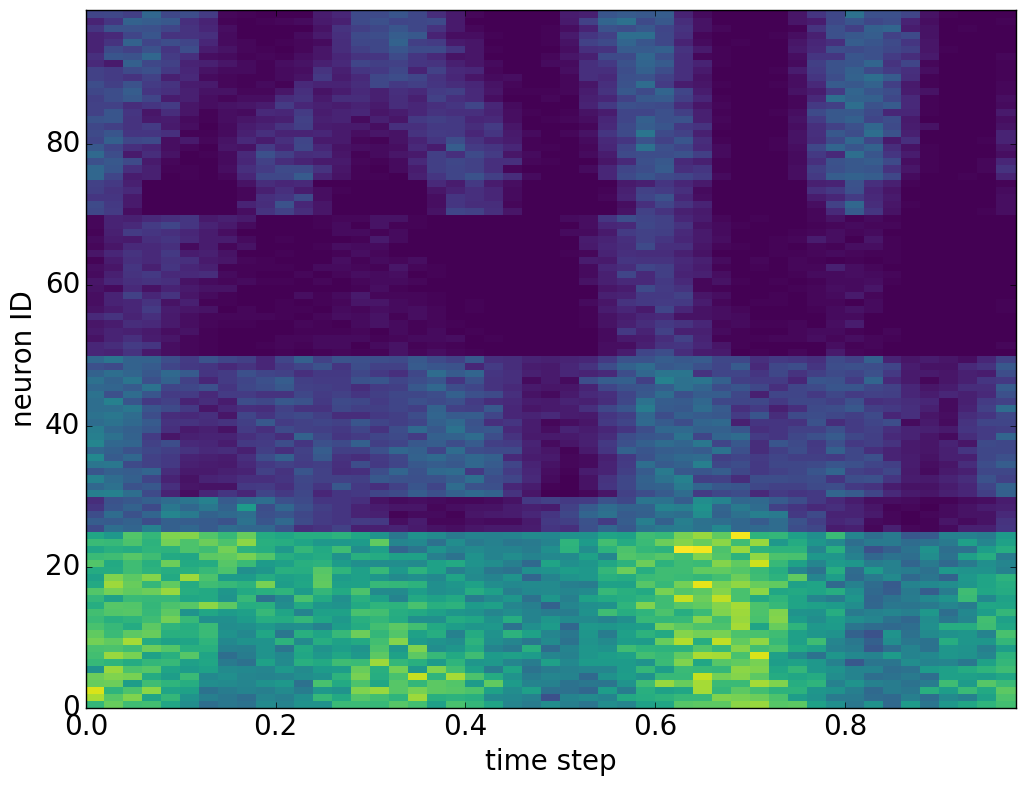

In [9]:
fig, ax = plt.subplots()
ax.pcolormesh(time, range(len(psth)), psth, cmap='viridis')
_ = plt.setp(ax, xlabel='time step', ylabel='neuron ID')
plt.autoscale(tight=True)

Many latent factor analyses involve analyzing the *covariance matrix* of data, which describes the extent to which features vary along with one another. The scikit-learn objects perform all of this under the hood, we need only feed in the raw data in the shape of `(n_samples, n_features)`.

In [15]:
psth = psth.T  # PCs across neurons

Below, we'll calculate the latent structure present in the data with a few algorithms.

In [16]:
# using Principal component analysis
pca_model = PCA(n_components=n_latent, whiten=True)
psth_pca_latent = pca_model.fit_transform(psth)

In [17]:
# using Factor Analysis
fa_model = FactorAnalysis(n_components=n_latent, tol=1e-7, max_iter=1000)
psth_norm = psth - psth.mean(axis=0) # normalize by mean
psth_fa_latent = fa_model.fit_transform(psth_norm)

In [19]:
# latent factor
pca_latent = np.dot(pca_model.components_, psth.T)
fa_latent = fa_model.components_

In [20]:
# We'll pull out the artificial latent variables for plotting here
latent_true = latent[:, 0, :]

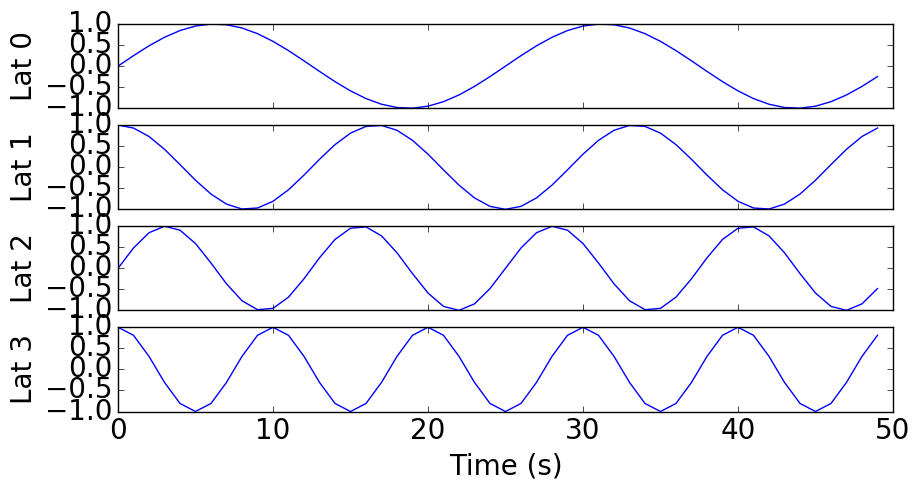

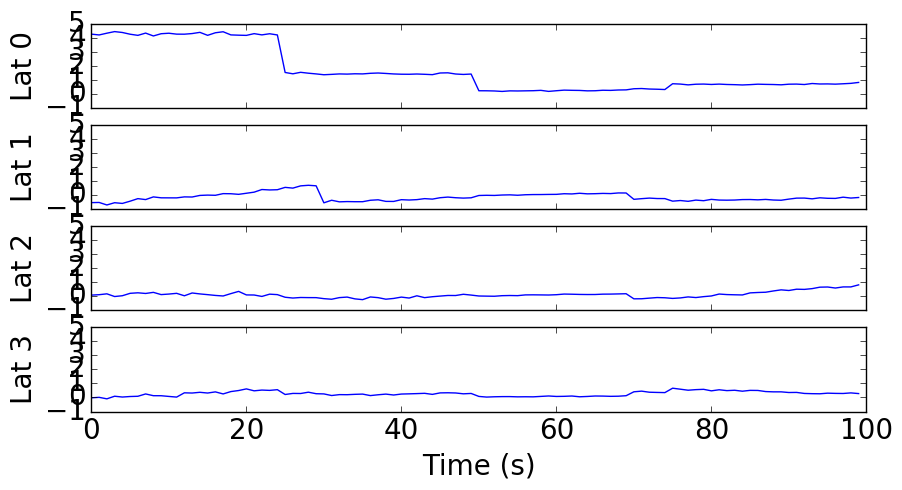

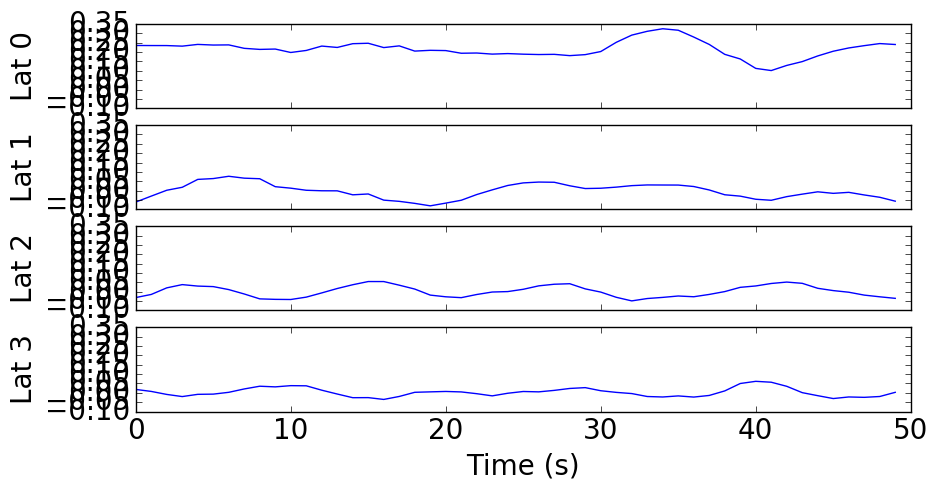

In [21]:
# Latent variable
plt_data = [latent_true, pca_latent, fa_latent]
for i_data in plt_data:
    fig, axs = plt.subplots(4, 1, figsize=(10, 5), sharex=True, sharey=True)
    for ii, ax in enumerate(axs):
        ax.plot(i_data[ii])
        _ = plt.setp(ax, ylabel='Lat {}'.format(ii))
    axs[-1].set_xlabel('Time (s)')

This doesn't look great...the underlying structure wasn't recovered well in either case. Let's try the same analysis on all of our data *without* averaging first.

### **Run analyses on single-trial data**
Here we'll concatenated trials for non-temporal methods 

In [24]:
spikes_concat = np.reshape(spikes, (n_neurons, n_time * n_trials), order='F')
spikes_concat.shape

(100, 5000)

In [26]:
# Convert to shape compatible with sklearn
psth_st = spikes_concat.T

In [27]:
# using Principal component analysis
pca_model = PCA(n_components=n_latent, whiten=True)
psth_pca_latent = pca_model.fit_transform(psth_st)

In [28]:
# using Factor Analysis
fa_model = FactorAnalysis(n_components=n_latent, tol=1e-7, max_iter=1000)
psth_fa_latent = fa_model.fit_transform(spikes_concat)

In [29]:
# latent factor
pca_latent = np.dot(pca_model.components_, psth)
fa_latent = np.mean(np.reshape(fa_model.components_, (n_latent, n_time, n_trials), order='F'), axis=2)

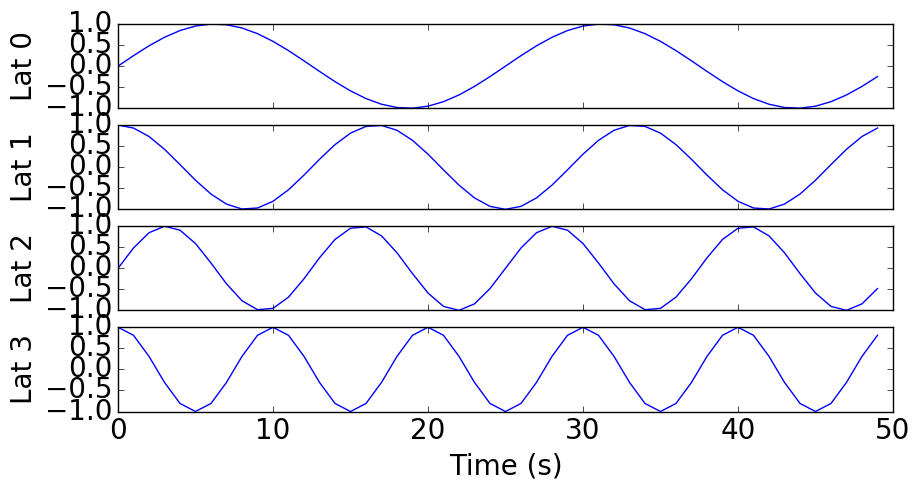

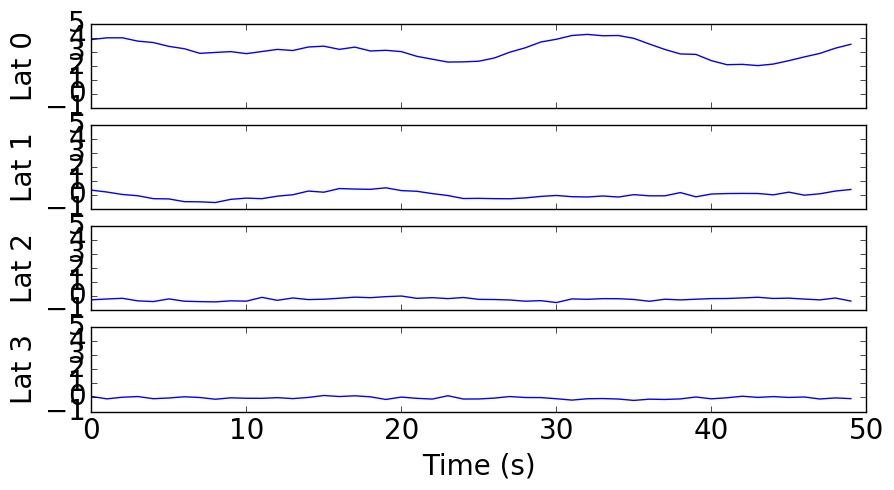

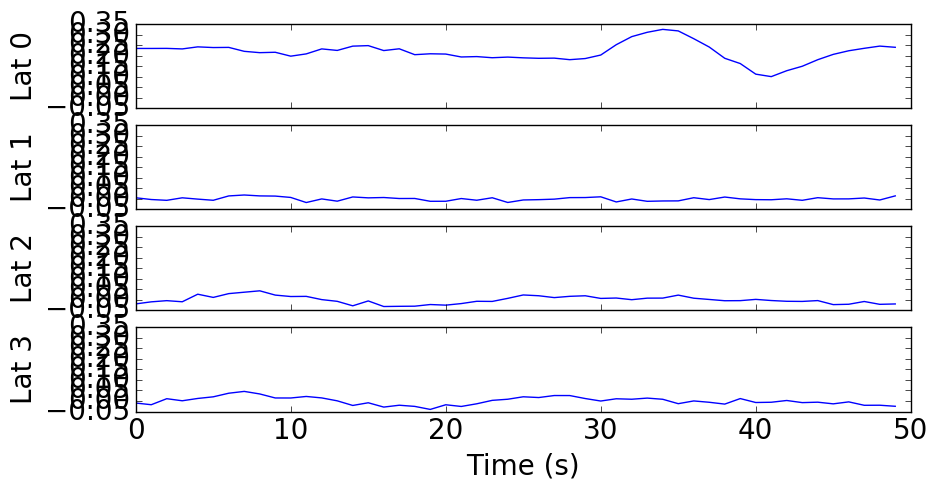

In [30]:
# Latent variable
latent_true = latent[:, 0, :]
plt_data = [latent_true, pca_latent, fa_latent]
for i_data in plt_data:
    fig, axs = plt.subplots(4, 1, figsize=(10, 5), sharex=True, sharey=True)
    for ii, ax in enumerate(axs):
        ax.plot(i_data[ii])
        _ = plt.setp(ax, ylabel='Lat {}'.format(ii))
    axs[-1].set_xlabel('Time (s)')

Did this do a better or worse job at reconstructing the latent variables?